In [1]:

import importlib
import data_prep as dp
importlib.reload(dp)
print(dir(dp))  # Check if functions appear now

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 'sort_by_date', 'yf']


In [39]:
import matplotlib.pyplot as plt

In [40]:
df = dp.macro_analysis('./../vix_news.csv', 'description', 'title')

Step 1: Loading data
Available columns in CSV: ['topic', 'title', 'description', 'source', 'published_at']
Columns after loading: ['topic', 'title', 'description', 'source', 'published_at', 'date']
Data shape after loading: (450, 6)
Step 2: Sorting by date
Min date: 2025-02-14 00:00:00, Max date: 2025-04-11 00:00:00
Columns after sorting: ['topic', 'title', 'description', 'source', 'published_at', 'date']
Step 3: Calculating summary sentiment
Columns after summary sentiment: ['topic', 'title', 'description', 'source', 'published_at', 'date', 'description_sentiment_summary', 'description_sentiment_label_summary']
Step 4: Calculating headline sentiment


[*********************100%***********************]  1 of 1 completed

Columns after headline sentiment: ['topic', 'title', 'description', 'source', 'published_at', 'date', 'description_sentiment_summary', 'description_sentiment_label_summary', 'title_sentiment_headline', 'title_sentiment_label_headline']
Step 5: Calculating sentiment stats
Inside calculate_sentiment_stats
Input df shape: (450, 10)
Input columns: ['topic', 'title', 'description', 'source', 'published_at', 'date', 'description_sentiment_summary', 'description_sentiment_label_summary', 'title_sentiment_headline', 'title_sentiment_label_headline']
Date min: 2025-02-14 00:00:00, max: 2025-04-11 00:00:00
Filtered df shape: (450, 10)
Looking for columns: description_sentiment_summary and title_sentiment_headline
Output columns: ['date', 'summary_mean', 'summary_min', 'summary_max', 'summary_pos_count', 'summary_neg_count', 'headline_mean', 'headline_min', 'headline_max', 'headline_pos_count', 'headline_neg_count', 'overall_mean', 'overall_min', 'overall_max', 'overall_pos_count', 'overall_neg_c

In [21]:
df.head()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,...,vix_target,vix_target_lag1,vix_target_lag2,vix_target_lag3,vix_target_lag4,vix_target_lag5,vix_target_lag6,vix_target_lag7,vix_target_lag8,vix_target_lag9
0,2025-02-14,0.477675,0.477675,0.477675,1,0,0.474713,0.474713,0.474713,1,...,14.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-17,-0.965174,-0.965174,-0.965174,0,1,-0.939103,-0.939103,-0.939103,0,...,15.35,14.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-02-18,0.372378,0.088780,0.655976,2,0,0.458808,0.083352,0.834263,2,...,15.35,15.35,14.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-02-19,-0.213531,-0.489639,0.062578,1,1,-0.276637,-0.639422,0.086147,1,...,15.27,15.35,15.35,14.77,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-02-20,-0.578604,-0.603541,-0.387781,0,12,0.083128,0.082524,0.086147,12,...,15.66,15.27,15.35,15.35,14.77,NaN,NaN,NaN,NaN,NaN


In [125]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

df['mean_sentiment_decay'] = df['overall_mean'].shift(1)  # Decay from yesterday
df['shock_pos'] = df['overall_max'] #best new
df['shock_neg'] = df['overall_min'] #worst new 
df['sentiment_dominance'] = df['summary_pos_count'] - df['summary_neg_count'] # which type of new is more prevalent (p/n)?
df['dominance_trigger'] = (df['sentiment_dominance'] < -5).astype(int) #if one type of news is more prevalent than the other, it will trigger a shock



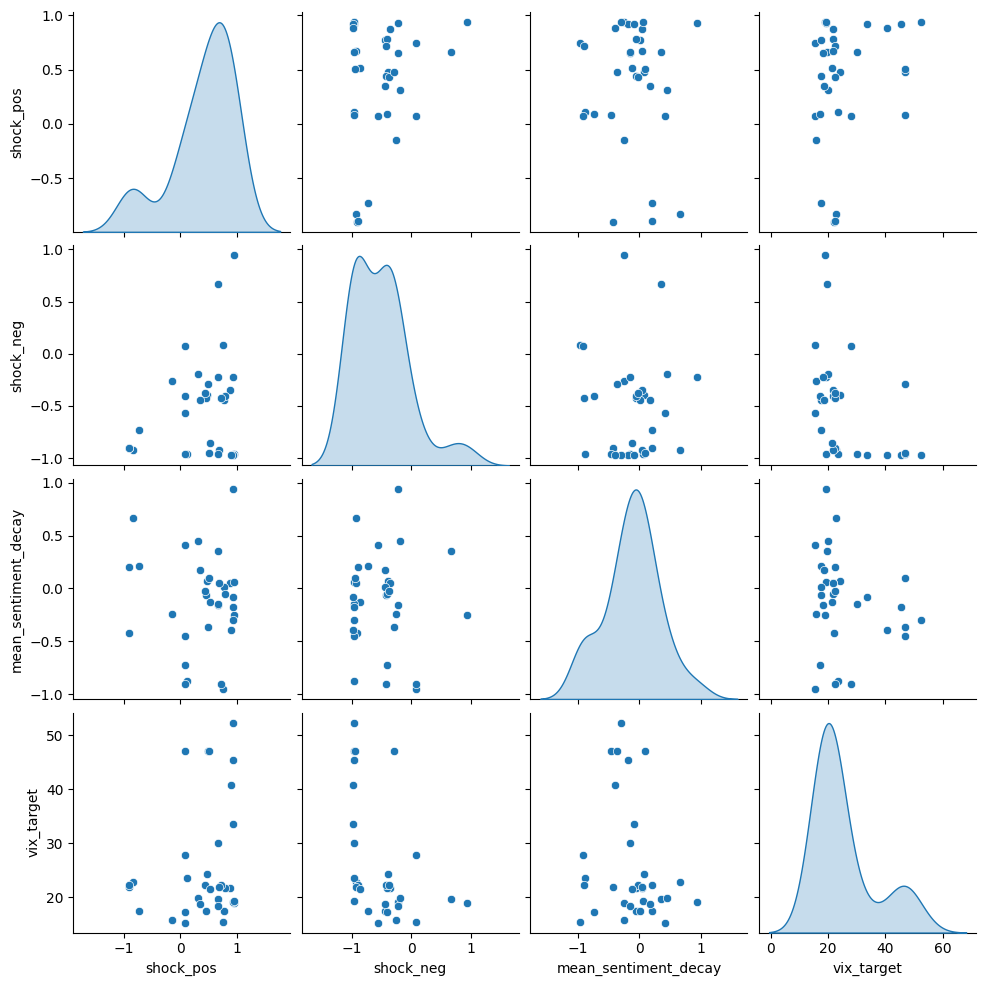

In [99]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target'], diag_kind='kde')


In [123]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]


In [ ]:

df_model = df.dropna(subset=feature_sets[0] + ['vix_target']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_target']

model = MarkovRegression(y, exog=X, k_regimes=2, switching_variance=False)
results = model.fit(disp=False)
print(f"Features: {feature_sets[0]}")
print(f"AIC: {results.aic:.3f}, LogL: {results.llf:.3f}")
print(results.summary().tables[0])
print("-" * 80)


Features: ['shock_neg', 'dominance_trigger']
AIC: 203.492, LogL: -92.746
                        Markov Switching Model Results                        
Dep. Variable:             vix_target   No. Observations:                   34
Model:               MarkovRegression   Log Likelihood                 -92.746
Date:                Fri, 11 Apr 2025   AIC                            203.492
Time:                        12:49:11   BIC                            217.229
Sample:                             0   HQIC                           208.177
                                 - 34                                         
Covariance Type:               approx                                         
--------------------------------------------------------------------------------


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [133]:
# Get the most likely regime at each time step
df_model['regime'] = results.smoothed_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.5 else 0)
selected_features = feature_sets[0]


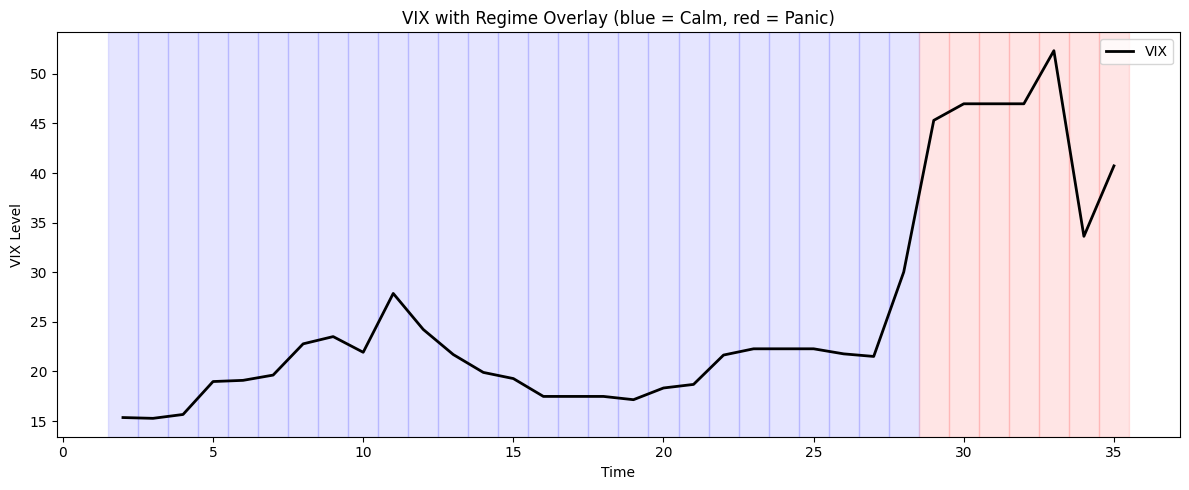

In [134]:
import matplotlib.pyplot as plt #this one is present vix. a step closer. (no predictions)

plt.figure(figsize=(12, 5))

# Plot VIX
plt.plot(df_model.index, df_model['vix_target'], label='VIX', color='black', linewidth=2)

# Color the background by regime
for i in range(len(df_model)):
    regime_color = 'red' if df_model['regime'].iloc[i] == 1 else 'blue'
    plt.axvspan(df_model.index[i] - 0.5, df_model.index[i] + 0.5, color=regime_color, alpha=0.1)

plt.title('VIX with Regime Overlay (blue = Calm, red = Panic)')
plt.xlabel('Time')
plt.ylabel('VIX Level')
plt.legend()
plt.tight_layout()
plt.show()


In [137]:
df['vix_target_t+1'] = df['vix_target'].shift(-1) #lag for predicting the vix level, not the regime prediction
df_model = df.dropna(subset=selected_features + ['vix_target_t+1']).copy()

X = df_model[selected_features]
y = df_model['vix_target_t+1']

model = MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    switching_variance=False
)
results = model.fit() #model for predicting the vix level t+1


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [138]:
print(results.summary())



                        Markov Switching Model Results                        
Dep. Variable:         vix_target_t+1   No. Observations:                   33
Model:               MarkovRegression   Log Likelihood                 -95.521
Date:                Fri, 11 Apr 2025   AIC                            209.042
Time:                        12:50:14   BIC                            222.511
Sample:                             0   HQIC                           213.574
                                 - 33                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1010      0.997     20.168      0.000      18.148      22.054
x1            -1.6321      1.600     -1.020      0.3

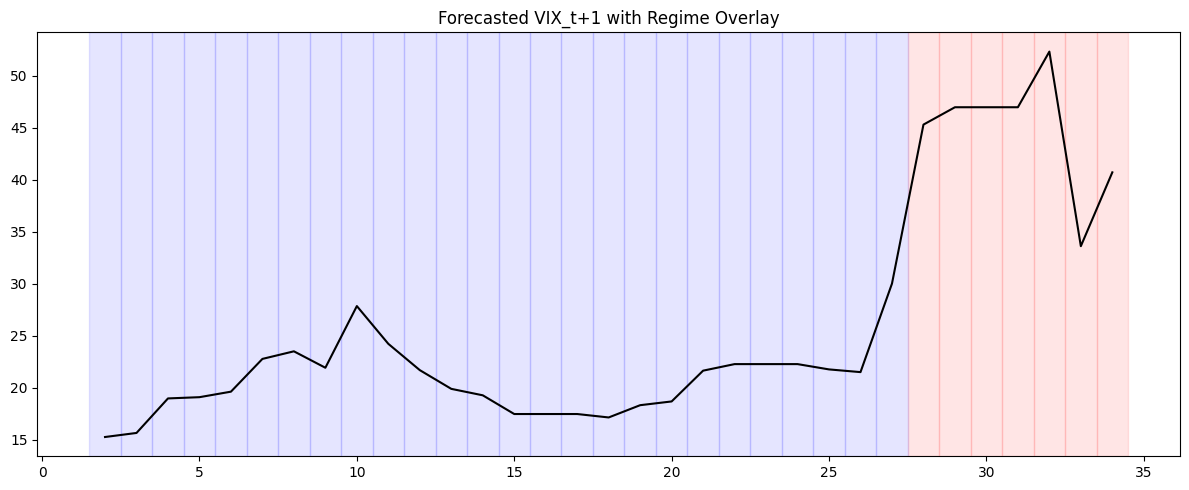

In [139]:
import matplotlib.pyplot as plt #graph vix t+1 with regime overlay

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['vix_target_t+1'], label='VIX_t+1', color='black')

for i in range(len(df_model)):
    color = 'red' if df_model['regime'].iloc[i] == 1 else 'blue'
    plt.axvspan(df_model.index[i] - 0.5, df_model.index[i] + 0.5, color=color, alpha=0.1)

plt.title('Forecasted VIX_t+1 with Regime Overlay')
plt.tight_layout()
plt.show()


In [140]:
df_model['regime_t'] = results.smoothed_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.5 else 0) #regime dataset for t


In [141]:
df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1


In [142]:
classification_df = df_model.dropna(subset=selected_features + ['regime_t+1']).copy() #classification dataset for t+1, for telling if regime is panic or not
X_cls = classification_df[selected_features]
y_cls = classification_df['regime_t+1']


In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
clf.fit(X_cls, y_cls)

# Evaluate
y_pred = clf.predict(X_cls)
print(classification_report(y_cls, y_pred))


              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        25
         1.0       1.00      0.71      0.83         7

    accuracy                           0.94        32
   macro avg       0.96      0.86      0.90        32
weighted avg       0.94      0.94      0.93        32



In [144]:
probs = clf.predict_proba(X_cls)[:, 1]
classification_df['panic_prob'] = probs


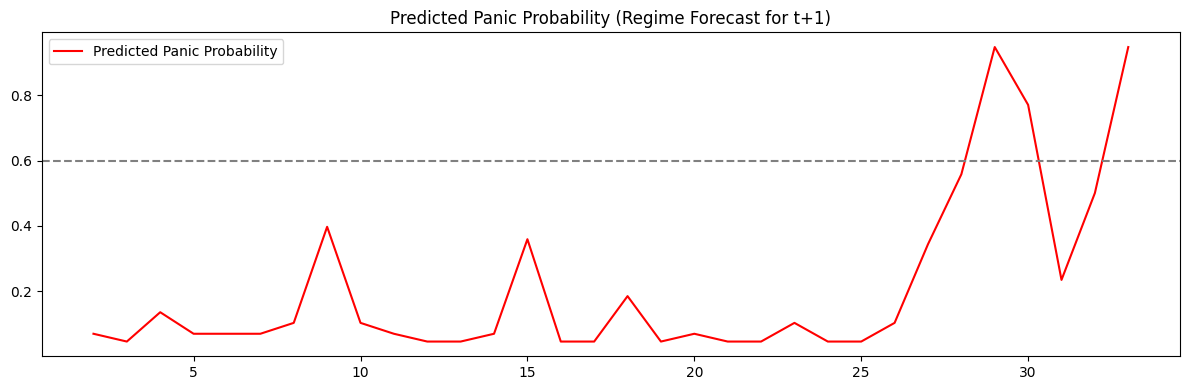

In [145]:
plt.figure(figsize=(12, 4))
plt.plot(classification_df.index, classification_df['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.6, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


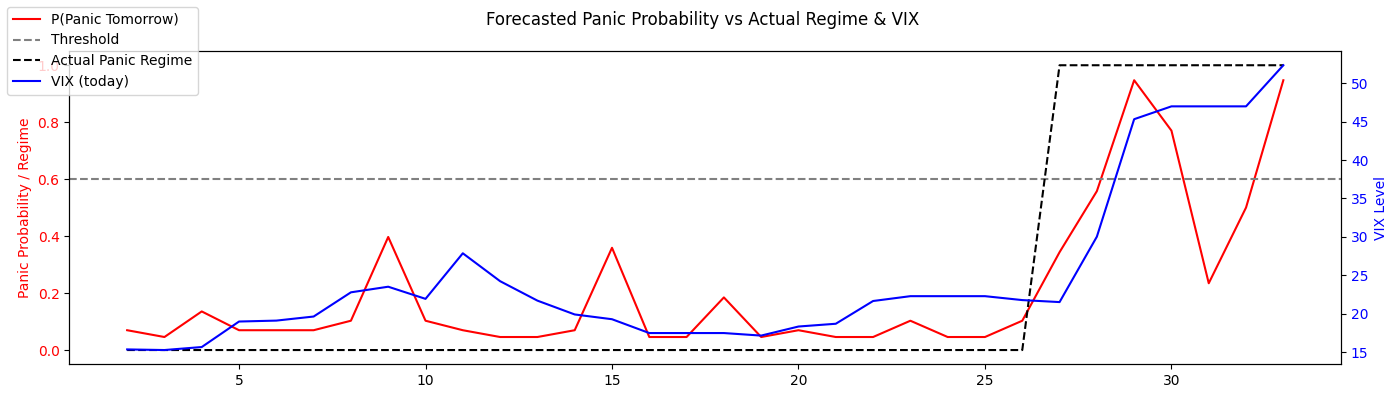

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
